# Lab 2

| Authors |
|---------|
| Austin Milne |
| Jude Bennett |
| William Ancich |

In [37]:
# Necessary Libraries
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
import pathlib
import statistics

# Read Raw Data
with open(r"data.json") as f:
    data = json.load(f)

# Accessible sensor names
Sensors = [
    {
        "name": "Long Range",
        "model": lambda x: 49.890422 / x + 0.046704563,
        "conversion": lambda x: 49.890422 / (x - 0.046704563),
        "std_dev": 0.012409
    },
    {
        "name": "Medium Range",
        "model": lambda x: 24.334172 / x - 0.030560244,
        "conversion": lambda x: 24.334172 / (x + 0.030560244),
        "std_dev": 0.010606
    }
]

# A matrix
A = np.array([[1.0,  0.05,   0.00125],
              [  0,   1.0,      0.05],
              [  0,     0,       1.0]])
 
# Noise applied to the forward kinematics.
process_noise_v_k_minus_1 = np.array([0.01,0.01,0.003])
     
# State model noise covariance matrix Q_k
Q_k = np.array([[0.3,   0,   0],
                [  0, 0.3,   0],
                [  0,   0, 0.3]])
                 
                         
# Sensor measurement noise covariance matrix R_k
R_k = np.array([[1.0,   0],
                [  0, 1.0]])  
                 
# Sensor noise
v_k = np.array([Sensors[0]["std_dev"], Sensors[1]["std_dev"]])


# Function to generate simulated sensor data for a given movement function
def generate_data(movement_function, noise_factor=1):
    # Create time span of 0 to 10 secons with 20hz sampling
    n = 200
    time = np.linspace(0, 10, n)
    x = movement_function(time)
    # For each sensor
    data = []
    for sensor in Sensors:
        # Generate a sensor data using the movement function, sensor function, and adding noise
        sensor_data = sensor["model"](x) + np.random.normal(0, sensor["std_dev"]*noise_factor, n)
        data.append(sensor_data)
    # Return the sensor data
    return data

# Single interation of the Extended Kalman Filter execution
def ekf(z_k_observation_vector, x_k_minus_1, P_k_minus_1, dk, H_k, h_x, R_k, Q_k):
    ######################### Predict #############################
    # Predict the state estimate at time k based on the state 
    # estimate at time k-1 and the control input applied at time k-1.
    x_k = A @ (x_k_minus_1)
             
    # print(f'State Estimate Before EKF={x_k}')
             
    # Predict the state covariance estimate based on the previous
    # covariance and some noise
    P_k = A @ P_k_minus_1 @ A.T + (Q_k)
         
    # Update
    measurement_residual_y_k = z_k_observation_vector - ((H_k @ x_k))
             
    # Calculate the measurement residual covariance
    S_k = H_k @ P_k @ H_k.T + R_k
         
    # Calculate the near-optimal Kalman gain
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
         
    # Calculate an updated state estimate for time k
    x_k = x_k + (K_k @ measurement_residual_y_k)
     
    # Update the state covariance estimate for time k
    P_k = P_k - (K_k @ H_k @ P_k)
     
    # Print the best (near-optimal) estimate of the current state of the robot
   # print(f'State Estimate After EKF={x_k}')
 
    # Return the updated state and covariance estimates
    return x_k, P_k

# Process dual sensor data using the Extended Kalman Filter
def ekfMain(Vdata, state, sens_cov, sys_cov):
     # We start at time k=1
    k = 1
    filtered_data = []
    # Time interval in seconds
    dk = 0.05
    # print(Vdata)
                    
    # [cm, cm/s, cm/s^2]
    state_estimate_k_minus_1 = np.array(state)
     
    # State covariance matrix P_k_minus_1
    P_k_minus_1 = np.array([[0.1,  0,   0],
                            [  0,0.1,   0],
                            [  0,  0, 0.1]])
    vData = np.swapaxes(Vdata,0,1)                         
    for k, obs_vector_z_k in enumerate(vData,start=1):
        V_m = obs_vector_z_k[1]
        V_l = obs_vector_z_k[0]

        obs_vector_z_k[1] = 24.334172/(V_m+0.030560244)
        obs_vector_z_k[0] = 49.89042/(V_l-0.046704563)

        h_x = np.array([-49.89042/(V_l-0.046704563),
                        -24.334172/(V_m+0.030560244)])

        # Jacobian matrix H_k
        H_k = np.array([[1,   0, 0],
                        [1,  0, 0]])
     
         
        # Run the Extended Kalman Filter and store the 
        # near-optimal state and covariance estimates
        optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k, # Most recent sensor measurement
            state_estimate_k_minus_1, # Our most recent estimate of the state
            P_k_minus_1, # Our most recent state covariance matrix
            dk, # Time interval
            H_k,
            h_x,
            sens_cov,
            sys_cov)
        
        filtered_data.append(optimal_state_estimate_k[0])
         
        # Get ready for the next timestep by updating the variable values
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k
    
    return filtered_data

# Run a suite of test on data and a given motion profile to illustrate performance of the EKF
def calculate_and_gen_graphs(title, file, data, profile, states=[80,30], show_attempted_profile=True):
    time = data["time"]
    distances = [np.array(sensor) for sensor in data["data"]]
    gen_distances = generate_data(profile)
    gen_distances_noisy = generate_data(profile, 2)

    # Plot the real and generated data
    plt.figure()
    for sensor in range(len(gen_distances)):
        plt.scatter(time, gen_distances[sensor], label=f"{Sensors[sensor]['name']} Generated", s=0.6)
    for sensor in range(len(distances)):
        plt.scatter(time, distances[sensor], label=f"{Sensors[sensor]['name']}", s=0.6)
    plt.title(f"Sensor Readings | {title}")
    plt.xlabel("Time (sec)")
    plt.ylabel("Sensor Reading (Volts)")
    plt.legend()
    plt.savefig(f"out/plots/{file}.png")
    plt.show()
    
    # Keep track of R^2 for various simulated data sets
    r2 = []

    # Kalman filter on the generated data
    processed_gen = ekfMain(gen_distances, [states[0],0.0,0.0], R_k, Q_k)
    r2.append({
        "Title": "Default",
        "R^2": r2_score(profile(time), processed_gen)
    })
    plt.figure()
    plt.plot(time, profile(time), label="Profile", color="red", linewidth=0.75)
    plt.plot(time, processed_gen, label="Filtered", color="green")
    for i, sensor in enumerate(Sensors):
        plt.scatter(time, sensor["conversion"](gen_distances[i]), label=f"{sensor['name']} Generated", s=0.5, color=["blue", "orange"][i])
    plt.title(f"Filtered vs Generated | {title}")
    plt.xlabel("Time (sec)")
    plt.ylabel("Distance (cm)")
    plt.ylim(0,100)
    plt.legend()
    plt.savefig(f"out/plots/{file}_kalman_gen.png")
    plt.show()
    
    # Kalman filter on the generated data, bad state estimate
    processed_gen = ekfMain(gen_distances, [states[1],-5.0,-10.0], R_k, Q_k)
    r2.append({
        "Title": "Bad State Est.",
        "R^2": r2_score(profile(time), processed_gen)
    })
    plt.figure()
    plt.plot(time, profile(time), label="Profile", color="red", linewidth=0.75)
    plt.plot(time, processed_gen, label="Filtered", color="green")
    for i, sensor in enumerate(Sensors):
        plt.scatter(time, sensor["conversion"](gen_distances[i]), label=f"{sensor['name']} Generated", s=0.5, color=["blue", "orange"][i])
    plt.title(f"Filtered vs Generated | {title} | Bad State Estimate")
    plt.xlabel("Time (sec)")
    plt.ylabel("Distance (cm)")
    plt.ylim(0,100)
    plt.legend()
    plt.savefig(f"out/plots/{file}_kalman_gen_bad_state.png")
    plt.show()
    
    # Kalman filter on the generated data, noisy sensors
    processed_gen = ekfMain(gen_distances_noisy, [states[0],0.0,0.0], R_k, Q_k)
    r2.append({
        "Title": "Noisy Sensors",
        "R^2": r2_score(profile(time), processed_gen)
    })
    plt.figure()
    plt.plot(time, profile(time), label="Profile", color="red", linewidth=0.75)
    plt.plot(time, processed_gen, label="Filtered", color="green")
    for i, sensor in enumerate(Sensors):
        plt.scatter(time, sensor["conversion"](gen_distances_noisy[i]), label=f"{sensor['name']} Generated", s=0.5, color=["blue", "orange"][i])
    plt.title(f"Filtered vs Generated | {title} | Noisy Sensors")
    plt.xlabel("Time (sec)")
    plt.ylabel("Distance (cm)")
    plt.ylim(0,100)
    plt.legend()
    plt.savefig(f"out/plots/{file}_kalman_gen_noisy_sensors.png")
    plt.show()
    
    # Kalman filter on the generated data, noisy system
    processed_gen = ekfMain(gen_distances, [states[0],0.0,0.0], R_k, Q_k*2)
    r2.append({
        "Title": "Noisy System",
        "R^2": r2_score(profile(time), processed_gen)
    })
    plt.figure()
    plt.plot(time, profile(time), label="Profile", color="red", linewidth=0.75)
    plt.plot(time, processed_gen, label="Filtered", color="green")
    for i, sensor in enumerate(Sensors):
        plt.scatter(time, sensor["conversion"](gen_distances[i]), label=f"{sensor['name']} Generated", s=0.5, color=["blue", "orange"][i])
    plt.title(f"Filtered vs Generated | {title} | Noisy System")
    plt.xlabel("Time (sec)")
    plt.ylabel("Distance (cm)")
    plt.ylim(0,100)
    plt.legend()
    plt.savefig(f"out/plots/{file}_kalman_gen_noisy_sensors.png")
    plt.show()
    
    # Create a pretty table of R^2 values
    r2_df = pd.DataFrame(r2)
    print(r2_df.to_string(index=False))

    # Kalman filter on the real data
    processed_real = ekfMain(distances, [states[0],0.0,0.0], R_k, Q_k)
    plt.figure()
    if show_attempted_profile:
        plt.plot(time, profile(time), label="Attempted Profile", color="red", linewidth=0.75)
    plt.plot(time, processed_real, label="Filtered", color="green")
    for i, sensor in enumerate(Sensors):
        plt.scatter(time, sensor["conversion"](distances[i]), label=f"{sensor['name']}", s=0.5, color=["blue", "orange"][i])
    plt.title(f"Filtered vs Experimental | {title}")
    plt.xlabel("Time (sec)")
    plt.ylabel("Distance (cm)")
    plt.ylim(0,100)
    plt.legend()
    plt.savefig(f"out/plots/{file}_kalman_real.png")
    plt.show()


## Part 1 - Smooth Point-to-Point Motion

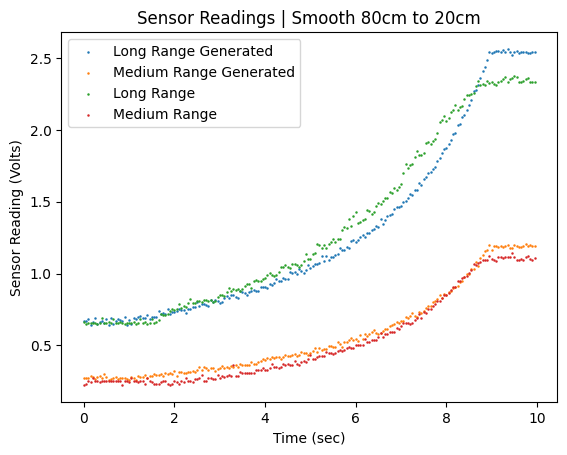

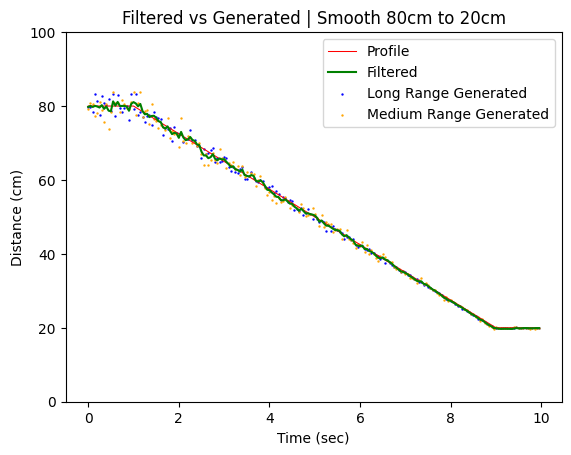

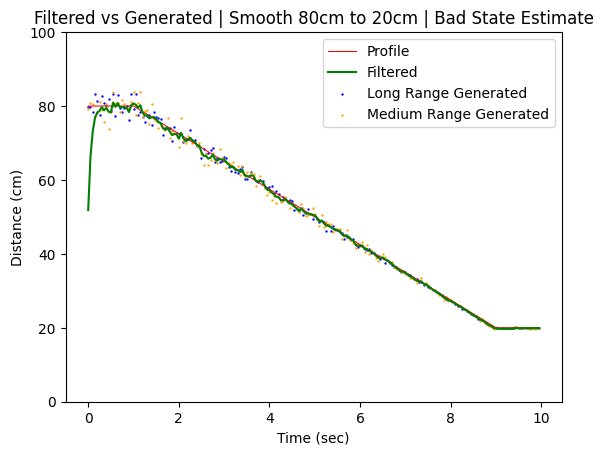

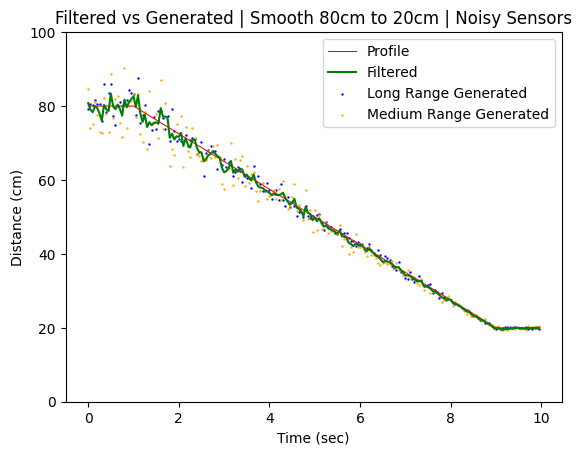

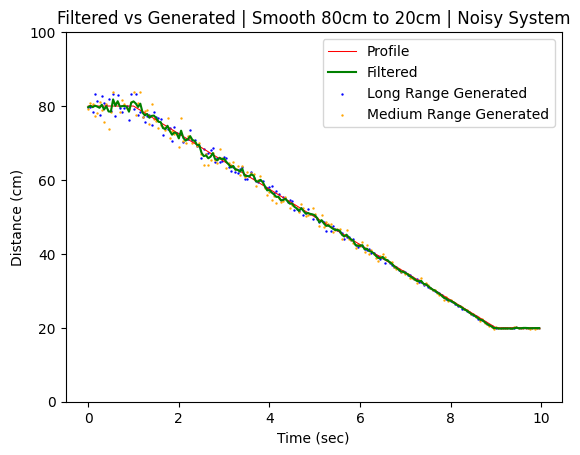

         Title      R^2
       Default 0.999345
Bad State Est. 0.986862
 Noisy Sensors 0.996896
  Noisy System 0.999188


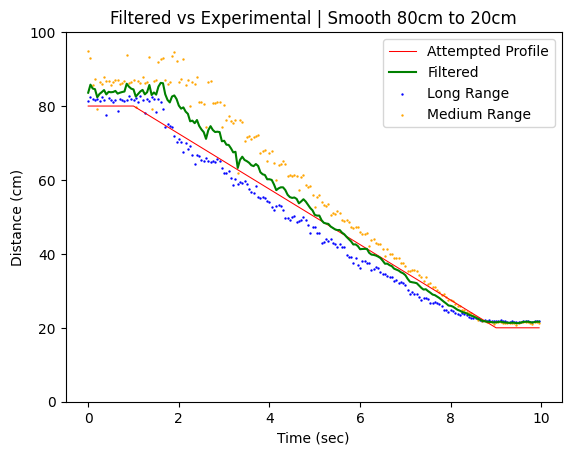

In [38]:
# Stay still for 1 second, move at a constant speed for 8 seconds, pause for 1 second
def movement_profile(times):
    data = []
    for t in times:
        if t < 1:
            data.append(80)
        elif t > 9:
            data.append(20)
        else:
            data.append(80 - 60 / 8 * (t - 1))
    return np.array(data)
    
# Process Graphs for Part 1
p1 = data["Part1"]
part_a = p1["smooth_80_to_20"]
calculate_and_gen_graphs(
    title = "Smooth 80cm to 20cm",
    file="Part1_smooth",
    data=part_a,
    profile=movement_profile
)

## Part 2 - Unsmooth Point-to-Point Motion

### deccelerate

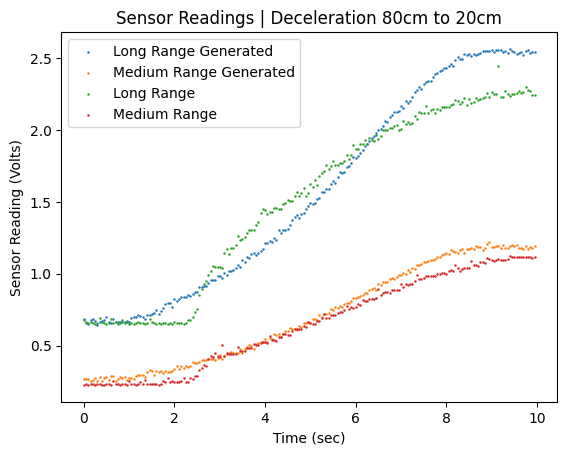

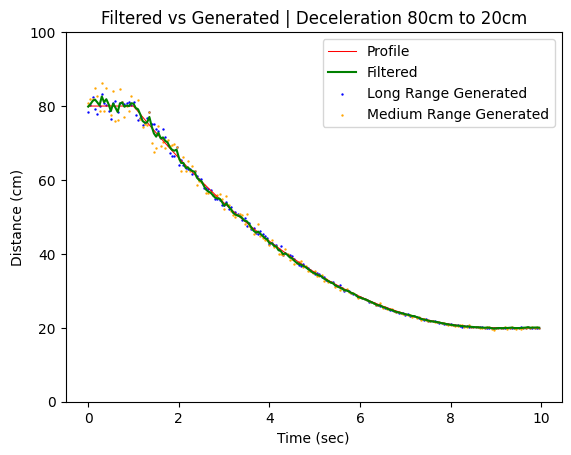

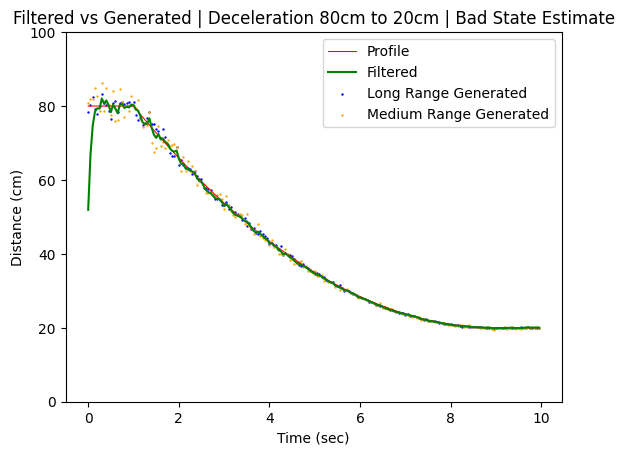

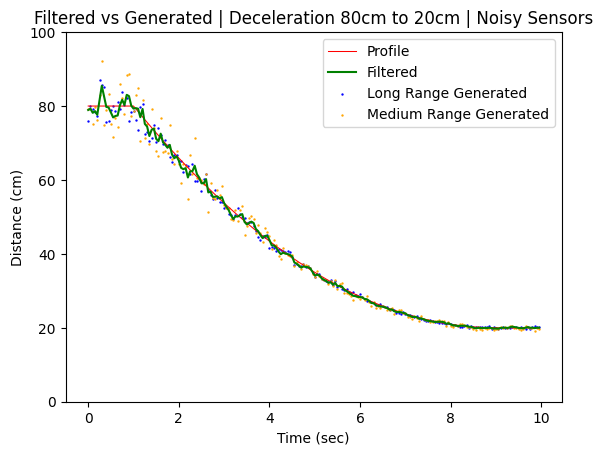

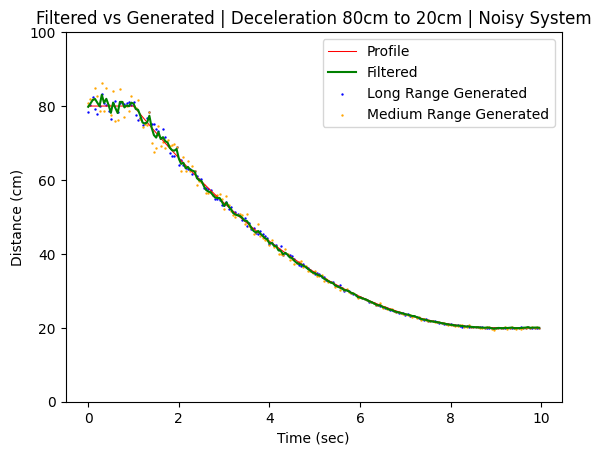

         Title      R^2
       Default 0.999418
Bad State Est. 0.988576
 Noisy Sensors 0.997932
  Noisy System 0.999246


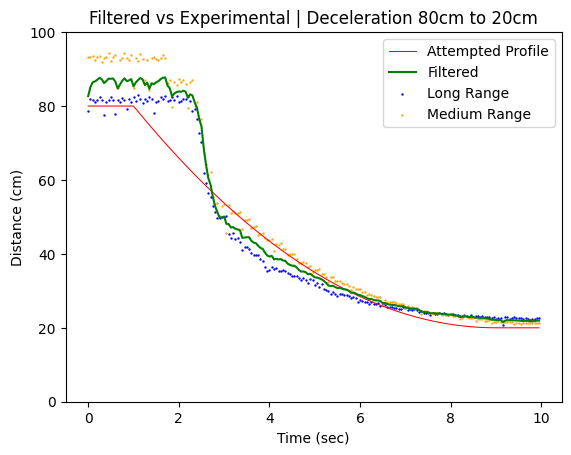

In [39]:
# Stay still for 1 second, instant movement and decelerate to stop for 8 seconds, pause 1 second
def movement_profile(times):
    data = []
    for t in times:
        if t < 1:
            data.append(80)
        elif t > 9:
            data.append(20)
        else:
            data.append(15/16 * (t-1)**2 - 15*(t-1) + 80)
    return np.array(data)

# Grab Part A data from the dictionary, make relevant copies
p2 = data["Part2"]
decel = p2["deccelerate"]
calculate_and_gen_graphs(
    title = "Deceleration 80cm to 20cm",
    file="Part2_decel",
    data=decel,
    profile=movement_profile
)


### double_lurch

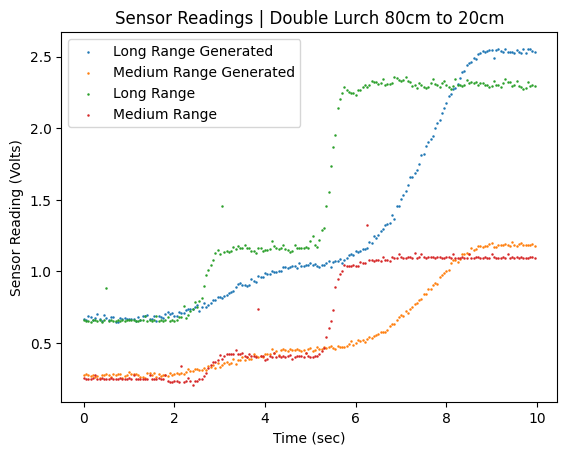

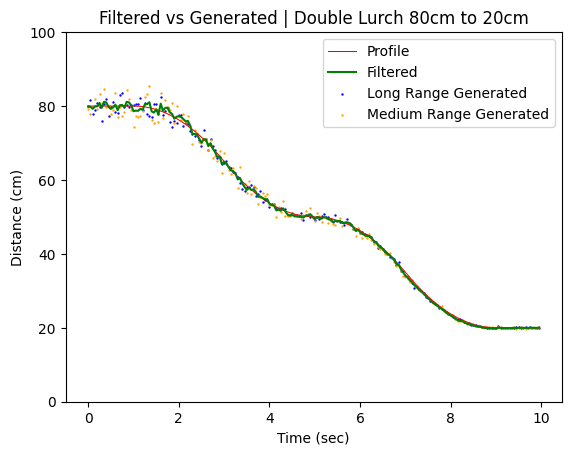

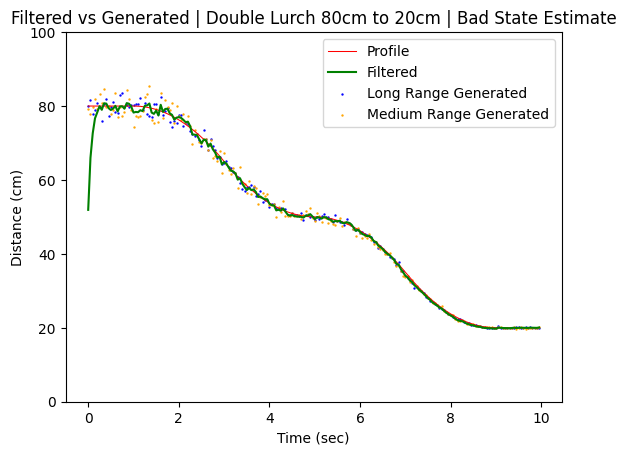

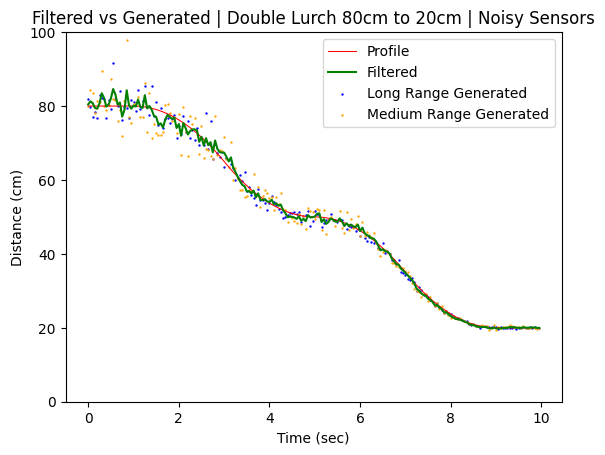

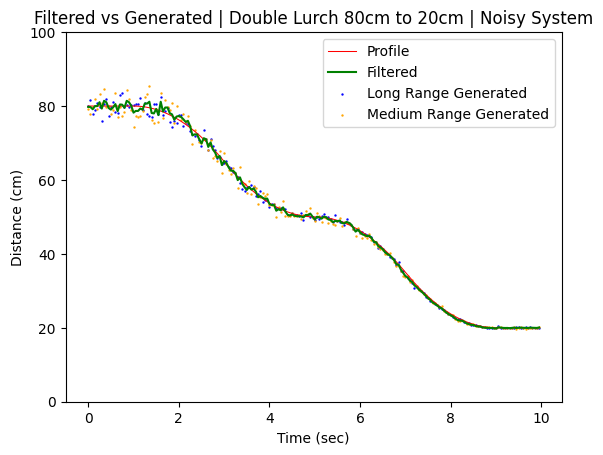

         Title      R^2
       Default 0.999240
Bad State Est. 0.987675
 Noisy Sensors 0.996927
  Noisy System 0.999034


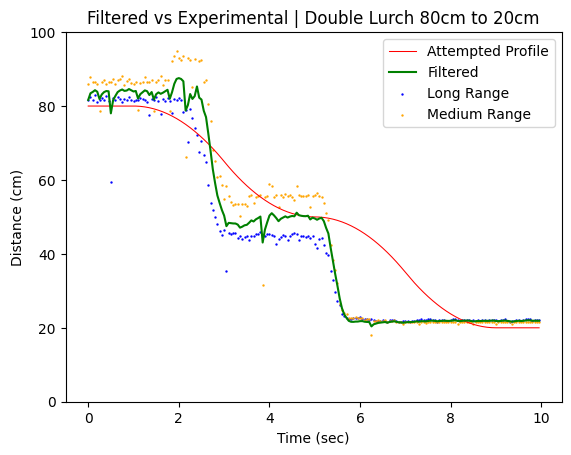

In [40]:
# Stay still for 1 seconds, double lurch to 20cm, pause 1 second
def movement_profile(times):
    data = []
    for t in times:
        if t < 1:
            data.append(80)
        elif t < 3:
            data.append(80 - (15/4) *(t-1)**2)
        elif t < 5:
            data.append(80 - 15 - (15/4)*4*(t-3) + (15/4)*(t-3)**2)
        elif t < 7:
            data.append(80 - 30 - (15/4) * (t-5)**2)
        elif t < 9:
            data.append(80 - 45 - (15/4)*4*(t-7) + (15/4)*(t-7)**2)
        else:
            data.append(20)
    return np.array(data)

# Graph the sensor readings for double_lurch movement
double_lurch = p2["double_lurch"]
calculate_and_gen_graphs(
    title = "Double Lurch 80cm to 20cm",
    file="Part2_double_lurch",
    data=double_lurch,
    profile=movement_profile
)


## Part 3 - Random Motion

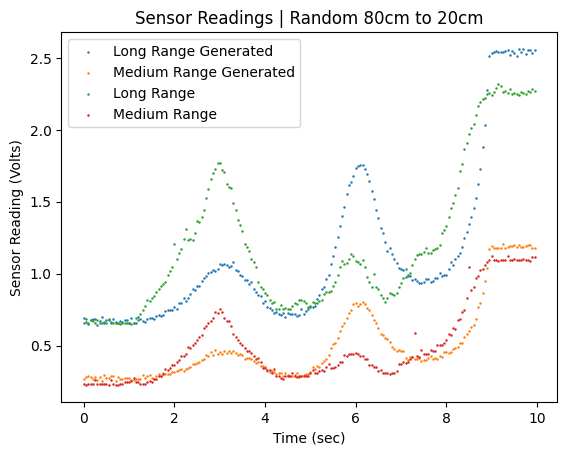

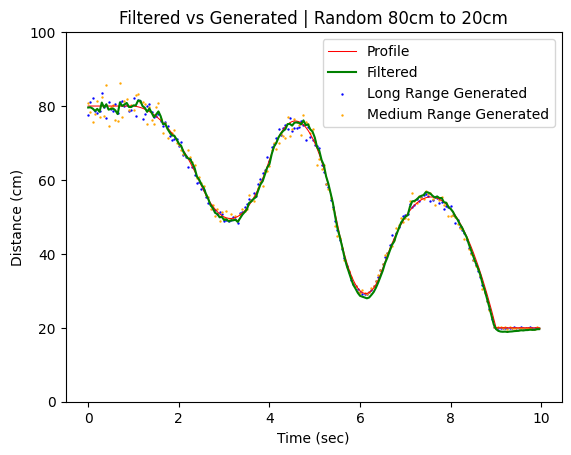

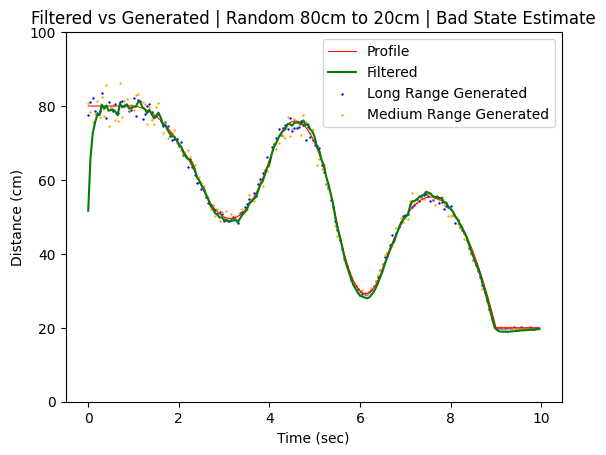

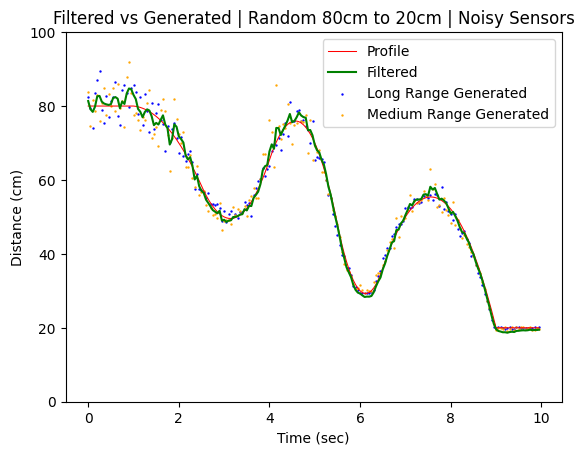

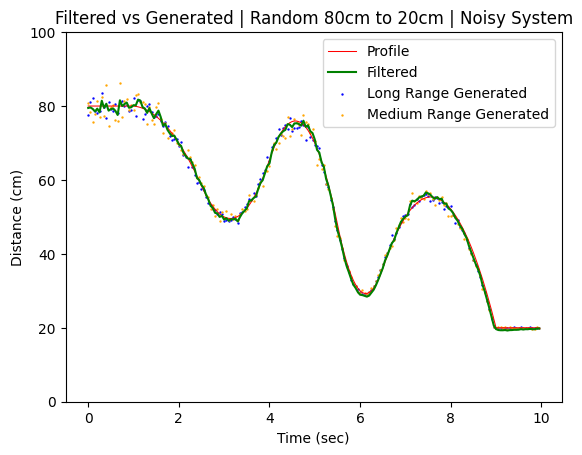

         Title      R^2
       Default 0.998201
Bad State Est. 0.983306
 Noisy Sensors 0.994943
  Noisy System 0.998177


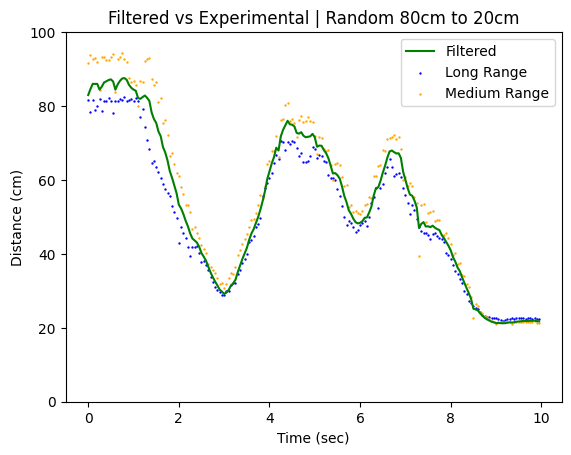

In [41]:
# Random Movement profile
def random_spline_curve():
    # Define time points (0 to 8 seconds) and corresponding y values
    t_points = np.array([0, 1, 2, 4, 5, 6, 8])  # Initial time points (start and end)
    y_points = np.array([80, 70, 50, 70, 30, 50, 20])  # Corresponding y values
    
    # Interpolate a smooth spline curve
    spline_curve = interp1d(t_points, y_points, kind='quadratic')
    
    return spline_curve

def movement_profile(times):
    spline_curve = random_spline_curve()
    values = []
    for t in times:
        if t < 1:
            values.append(80)
        elif t > 9:
            values.append(20)
        else:
            values.append(spline_curve(t-1))
    return np.array(values)

# Grab Part A data from the dictionary, make relevant copies
p3 = data["Part3"]
random = p3["random"]
calculate_and_gen_graphs(
    title = "Random 80cm to 20cm",
    file="Part3_random",
    data=random,
    profile=movement_profile,
    show_attempted_profile=False
)

## Part 4 - Stationary

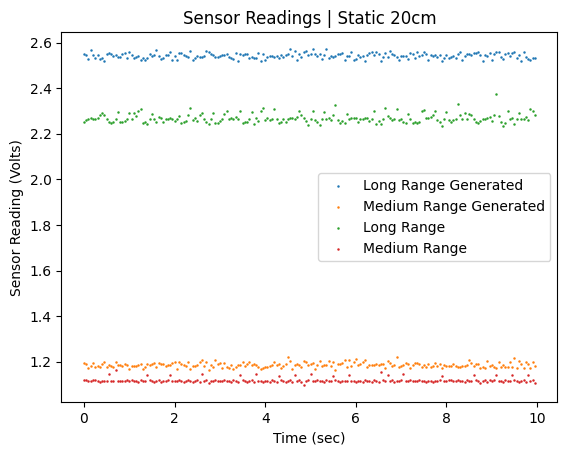

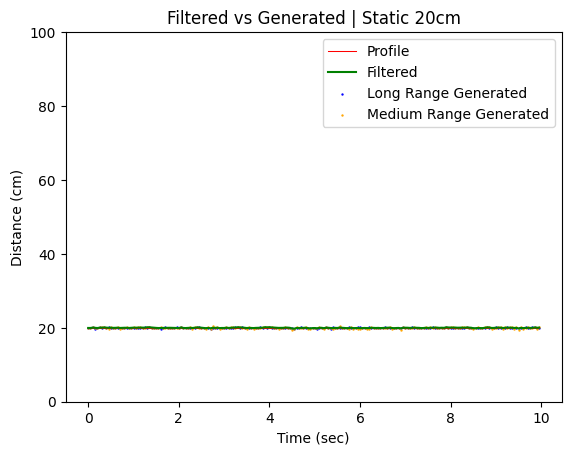

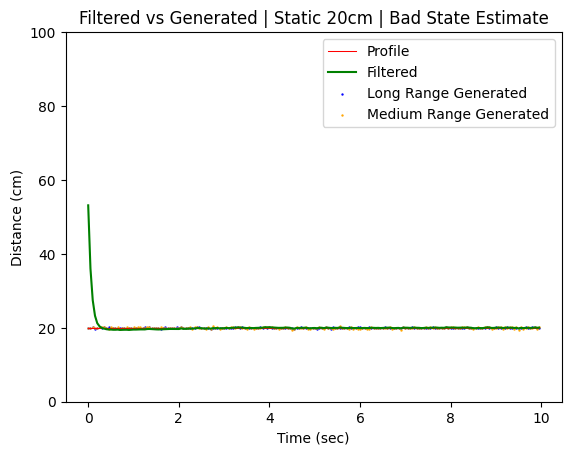

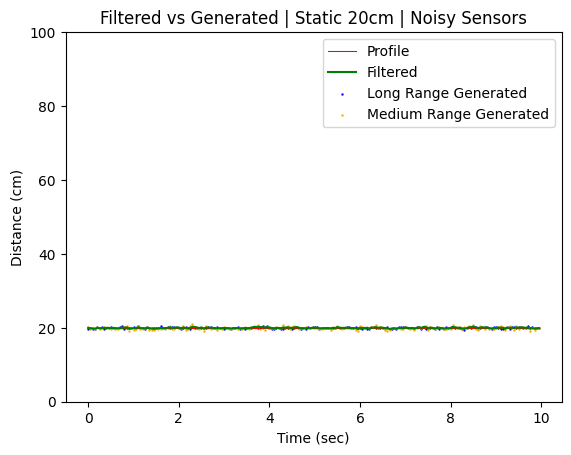

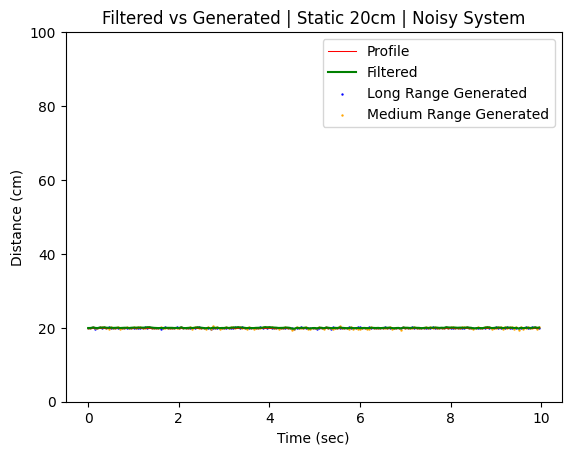

         Title  R^2
       Default  0.0
Bad State Est.  0.0
 Noisy Sensors  0.0
  Noisy System  0.0


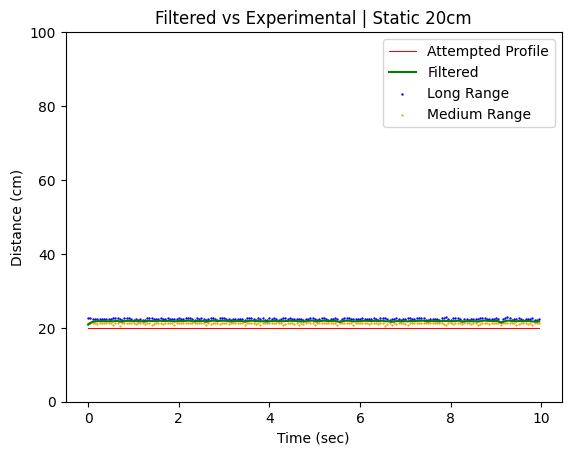

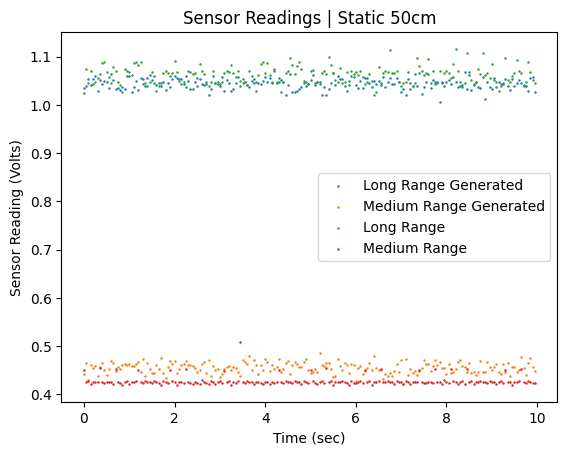

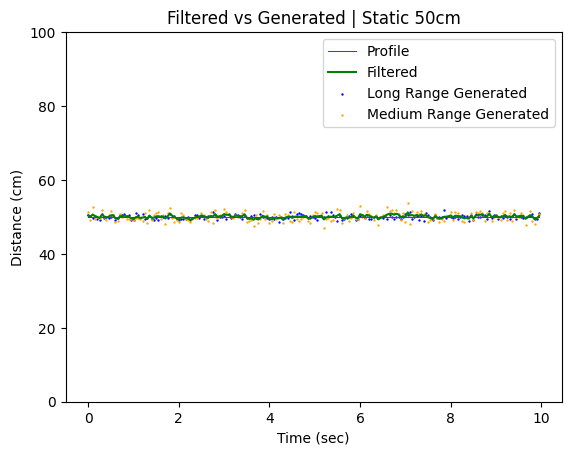

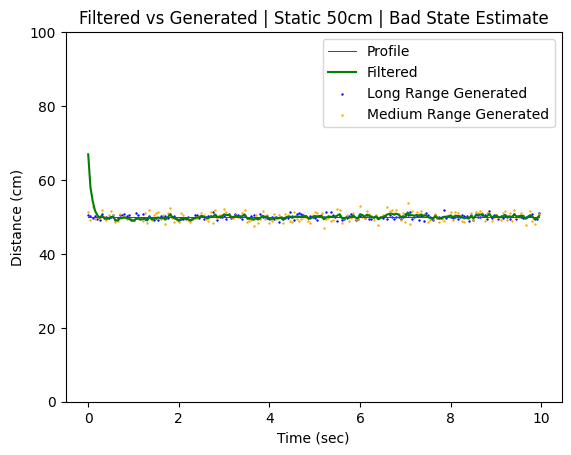

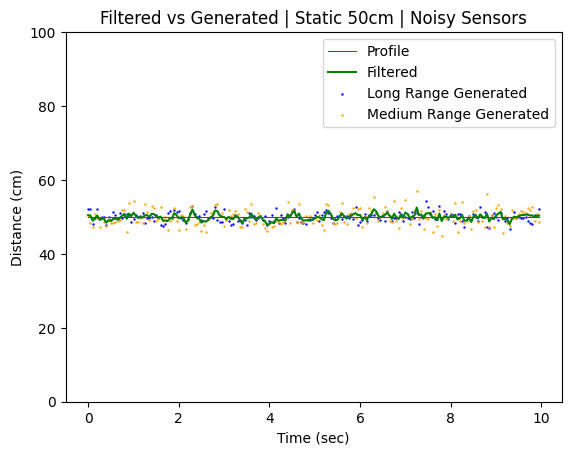

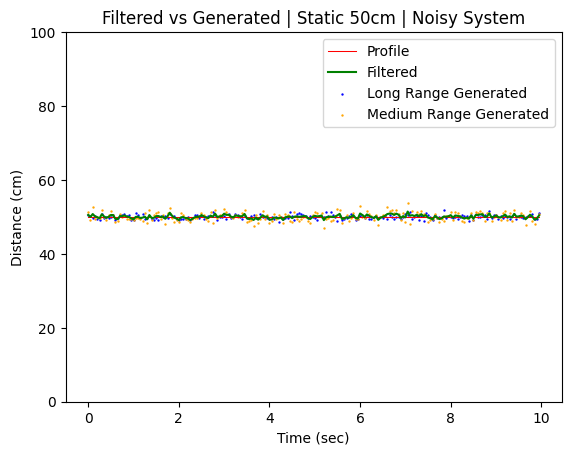

         Title  R^2
       Default  0.0
Bad State Est.  0.0
 Noisy Sensors  0.0
  Noisy System  0.0


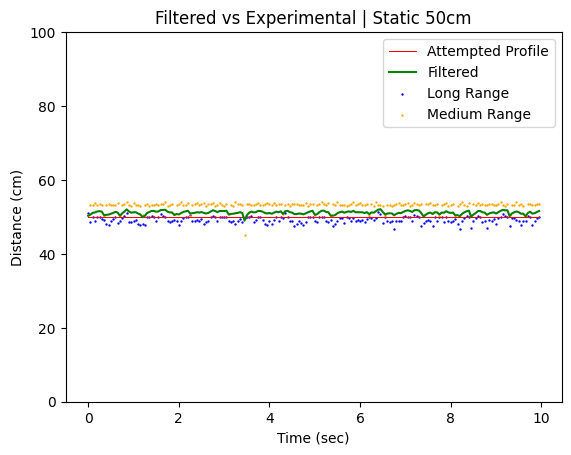

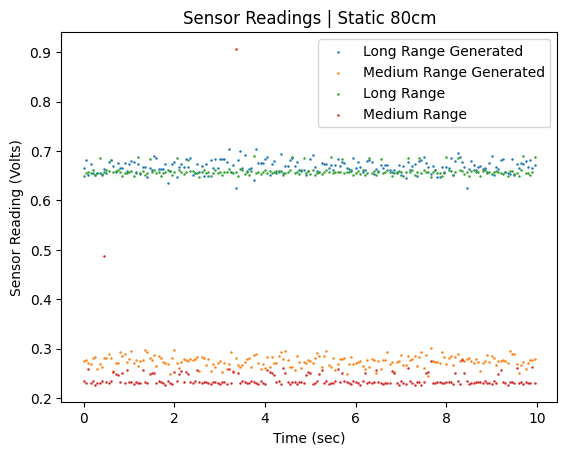

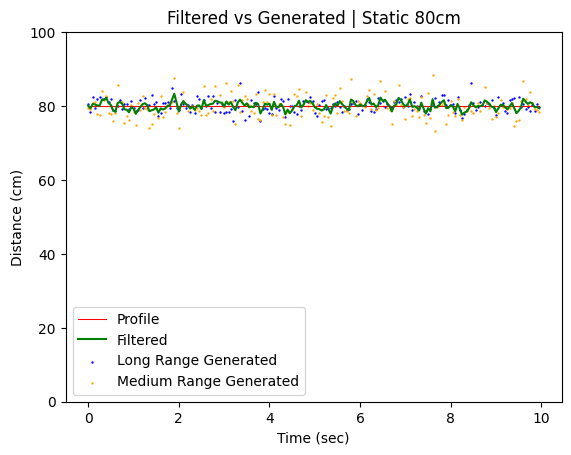

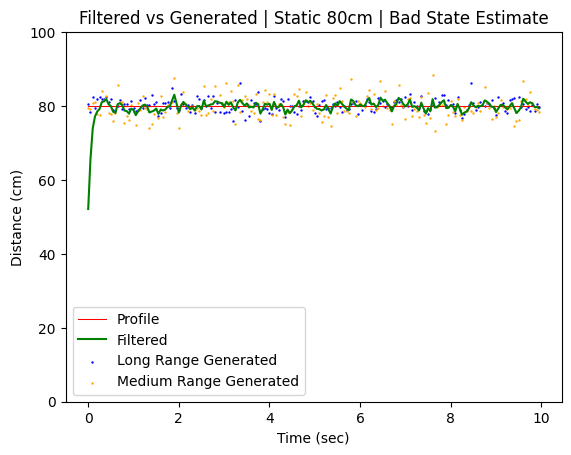

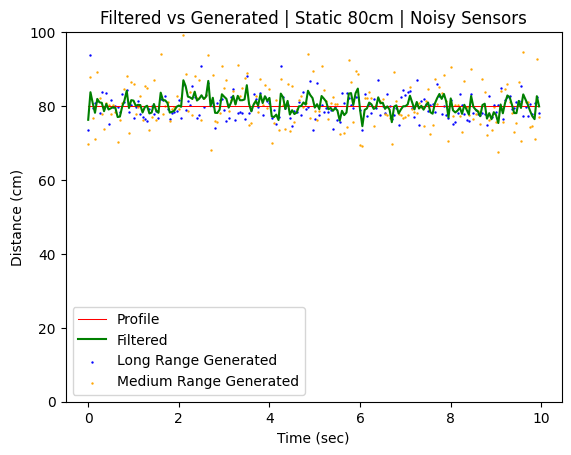

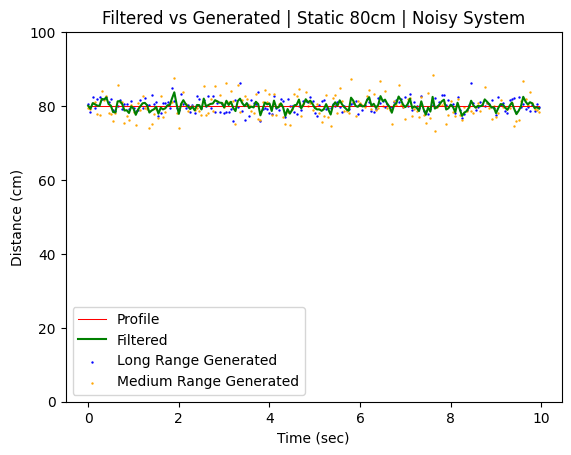

         Title  R^2
       Default  0.0
Bad State Est.  0.0
 Noisy Sensors  0.0
  Noisy System  0.0


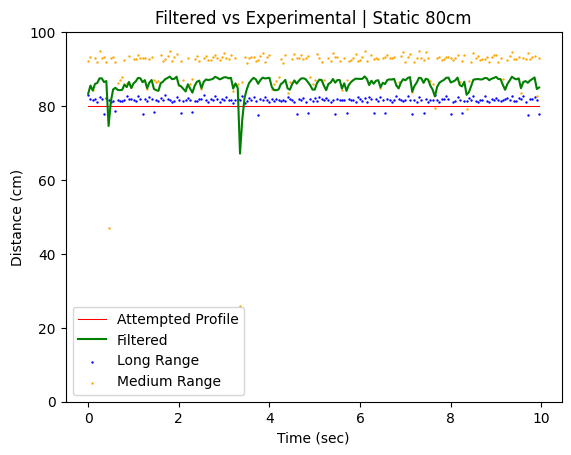

In [42]:

# Grab Part A data from the dictionary, make relevant copies
p4 = data["Part4"]
static_20 = p4["20cm_stationary"]
calculate_and_gen_graphs(
    title = "Static 20cm",
    file="Part4_static_20",
    data=static_20,
    profile=lambda times: np.array([20]*len(times)),
    states=[20, 80],
    show_attempted_profile=True
)
static_50 = p4["50cm_stationary"]
calculate_and_gen_graphs(
    title = "Static 50cm",
    file="Part4_static_50",
    data=static_50,
    profile=lambda times: np.array([50]*len(times)),
    states=[50, 80],
    show_attempted_profile=True
)
static_80 = p4["80cm_stationary"]
calculate_and_gen_graphs(
    title = "Static 80cm",
    file="Part4_static_80",
    data=static_80,
    profile=lambda times: np.array([80]*len(times)),
    states=[80,30],
    show_attempted_profile=True
)


## Part 5 - Poor Sensing Conditions

### stationary

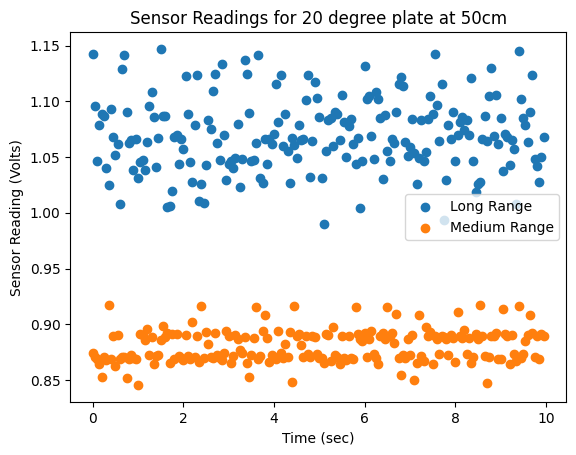

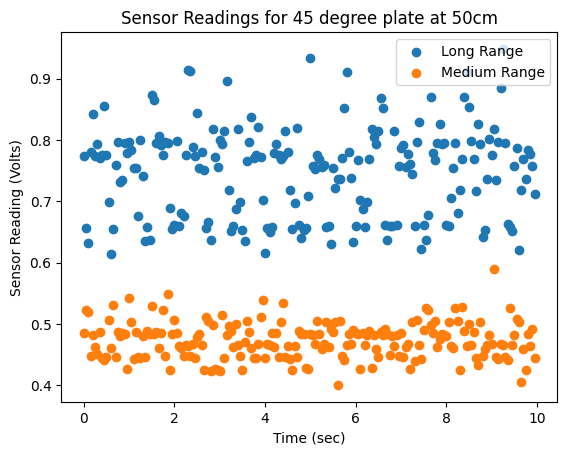

        Case  Long Var.  Long Std. Dev.  Medium Var.  Medium Std. Dev.
20 deg Plate   0.001083        0.032907     0.000216          0.014694
45 deg Plate   0.005398        0.073473     0.000879          0.029653


In [43]:
# Grab Part A data from the dictionary, make relevant copies
p5 = data["Part5"]
variances = []

# Graph the sensor readings for 20 degree plate at 50cm (50cm_stationary_20deg_CCW_metal_plate)
plate_20deg_50cm = p5["50cm_stationary_20deg_CCW_metal_plate"]
time = plate_20deg_50cm["time"]
distances = plate_20deg_50cm["data"]
variances.append({
    "Case": "20 deg Plate",
    "Long Var.": statistics.variance(distances[0]),
    "Long Std. Dev.": statistics.stdev(distances[0]),
    "Medium Var.": statistics.variance(distances[1]),
    "Medium Std. Dev.": statistics.stdev(distances[1]),
})

plt.figure()
for sensor in range(len(distances)):
    plt.scatter(time, distances[sensor], label=f"{Sensors[sensor]['name']}")
plt.title("Sensor Readings for 20 degree plate at 50cm")
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Sensor Reading (Volts)")
plt.savefig(f"out/plots/Part5_20deg_50cm.png")
plt.show()

# Graph sensor reading for 45 degree plate at 50cm (50cm_stationary_45deg_CCW_metal_plate)
plate_45deg_50cm = p5["50cm_stationary_45deg_CCW_metal_plate"]
time = plate_45deg_50cm["time"]
distances = plate_45deg_50cm["data"]
variances.append({
    "Case": "45 deg Plate",
    "Long Var.": statistics.variance(distances[0]),
    "Long Std. Dev.": statistics.stdev(distances[0]),
    "Medium Var.": statistics.variance(distances[1]),
    "Medium Std. Dev.": statistics.stdev(distances[1]),
})

plt.figure()
for sensor in range(len(distances)):
    plt.scatter(time, distances[sensor], label=f"{Sensors[sensor]['name']}")
plt.title("Sensor Readings for 45 degree plate at 50cm")
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Sensor Reading (Volts)")
plt.savefig(f"out/plots/Part5_45deg_50cm.png")
plt.show()

# Display the variances
var_df = pd.DataFrame(variances)
print(var_df.to_string(index=False))


### movement

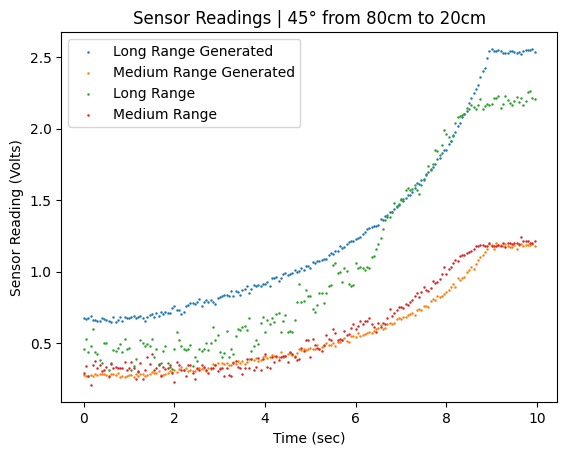

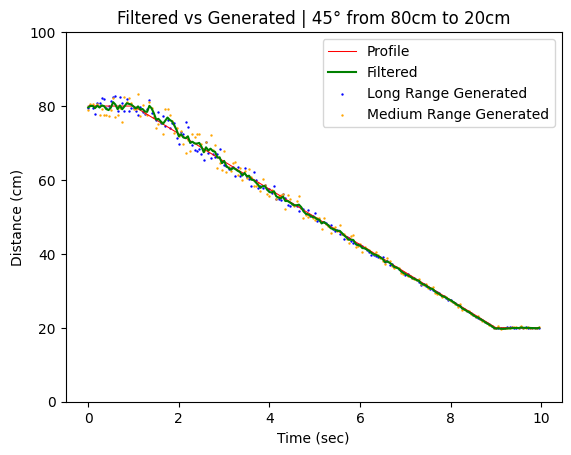

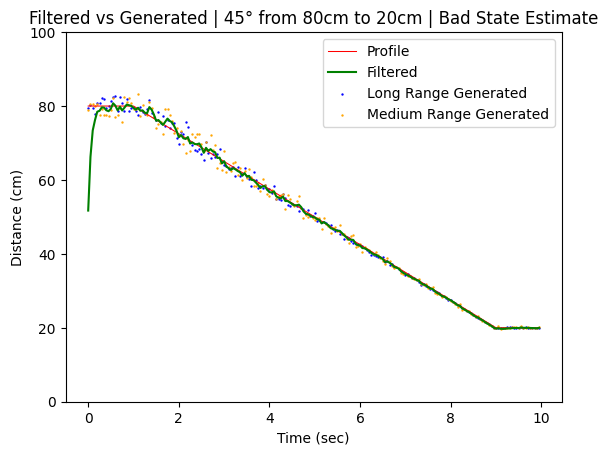

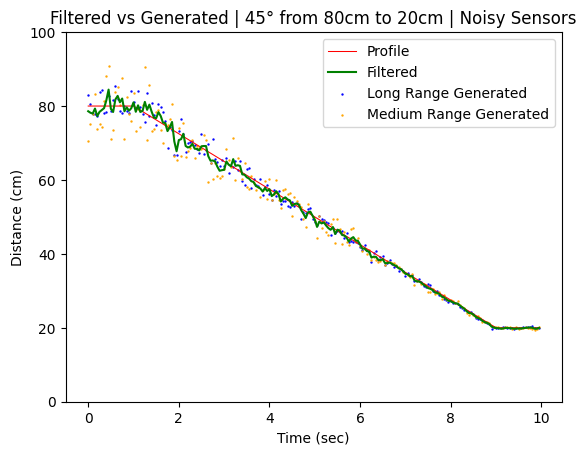

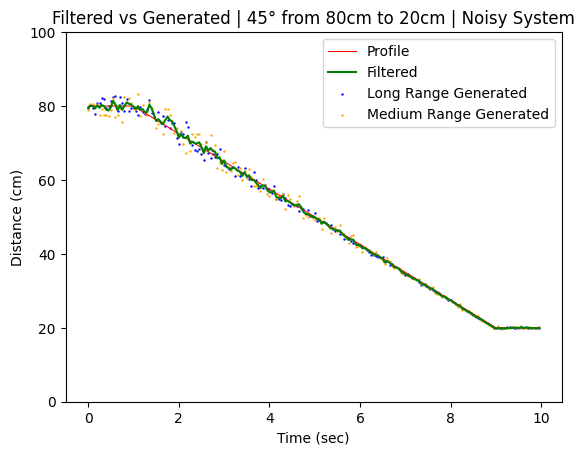

         Title      R^2
       Default 0.999149
Bad State Est. 0.986741
 Noisy Sensors 0.996861
  Noisy System 0.999015


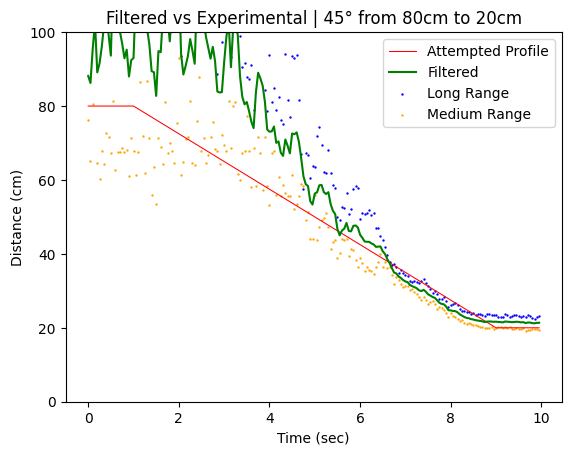

In [44]:
# Still for 1 second, move at a constant speed for 8 seconds, pause for 1 second
def movement_profile (t):
    data = []
    for i in t:
        if i < 1:
            data.append(80)
        elif i > 9:
            data.append(20)
        else:
            data.append(80 - 60 / 8 * (i - 1))
    return np.array(data)

# Graph sensor reading for 45 degree plate moving from 80cm to 20cm (80cm_to_20cm_45deg_CCW_metal_plate)
plate_45deg_80to20 = p5["80_to_20_45deg_CCW_metal_plate"]
calculate_and_gen_graphs(
    title = "45° from 80cm to 20cm",
    file="Part5_80to20_45deg",
    data=plate_45deg_80to20,
    profile=movement_profile
)
